<a href="https://colab.research.google.com/github/jialun1221/scRNA-seq/blob/main/DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####Install packages

In [ ]:
!pip3 install torch torchvision matplotlib
!pip3 install --upgrade pillow==8.1.0

import sys
#if branch is stable, will install via pypi, else will install from source
branch = "stable"
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and branch == "stable":
    !pip install --quiet scvi-tools[tutorials]
elif IN_COLAB and branch != "stable":
    !pip install --quiet --upgrade jsonschema
    !pip install --quiet git+https://github.com/yoseflab/scvi-tools@$branch#egg=scvi-tools[tutorials]

In [ ]:
import scvi
import scanpy as sc
import pandas as pd
import numpy as np

INFO:pytorch_lightning.utilities.seed:Global seed set to 0


In [ ]:
import importlib
required_libraries = ['torch', 'torchvision', 'PIL', 'matplotlib', 
                      'numpy', 'pandas']
for lib in required_libraries:
    if importlib.util.find_spec(lib) is None:
        print("%s unavailable" % lib)

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! cd drive
! ls drive/MyDrive/lily\ ml/
! ls drive/MyDrive/pd_astro-2.h5ad

drive/MyDrive/pd_astro-2.h5ad


In [ ]:
adata = scvi.data.read_h5ad("drive/MyDrive/pca_in_obsm.h5ad")

In [ ]:
b = scvi.data.read_h5ad("drive/MyDrive/pd_astro-2.h5ad")

In [ ]:
#Dimension check. Should have n_obs × n_vars = 7491 x 3849 
print(adata) 

AnnData object with n_obs × n_vars = 7491 × 3849
    obs: 'index', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Cell_Subtype', 'Cell_Type', 'disease__ontology_label', 'organ__ontology_label', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito'
    var: 'features', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mito', 'log1p_mean_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'


In [ ]:
adata.obs

####**Select out your training data and labels, slightly modify it for training.**

In [ ]:
adata.obs = adata.obs.reset_index() #reset the index for X, so the column number starts from 0

In [ ]:
X = pd.DataFrame(adata.obsm['X_pca'])
y = adata.obs['disease__ontology_label'].replace({"normal": "0", "Parkinson disease": "1"})



```
scRNAdf_X = pd.DataFrame(adata.X)
scRNAdf_Y = adata.obs['disease__ontology_label'].reset_index()
scRNAdf = scRNAdf_X.join(scRNAdf_Y) 
no_index = scRNAdf.drop('index', axis=1)
type(no_index)
newdf = no_index.drop(index=no_index[no_index['disease__ontology_label'].str.contains('Lewy body dementia')].index)
newdf["disease__ontology_label"] = newdf["disease__ontology_label"].replace({"normal": "0", "Parkinson disease": "1"})
X = newdf[list(newdf.columns[0:3799])]
y = newdf['disease__ontology_label']
print(X.shape, y.shape)
print(X)
```



####Set up the testing/training set.

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import scanpy as sc

from torch.utils.data import TensorDataset

use_gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if use_gpu else "cpu")

print("Torch version: ", torch.__version__)
print("GPU Available: {}".format(use_gpu))

Torch version:  1.12.1+cu113
GPU Available: True


In [ ]:
seed = 4321
np.random.seed(seed) # Set the random seed of numpy for the data split.
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [ ]:
#TO-DO: Cross validation

In [ ]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

In [ ]:
#train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(type(X_train), type(X_test), type(y_train), type(y_test))

(5992, 50) (1499, 50) (5992,) (1499,)
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


Take some data from test set for validation.

In [ ]:
#Get the validation dataset splitted
X_val = X_test.head(499)
X_test = X_test.tail(1000)
y_val = y_test.head(499)
y_test = y_test.tail(1000)
print(X_val.shape, X_test.shape, y_val.shape, y_test.shape)

(499, 50) (1000, 50) (499,) (1000,)


In [ ]:
# Type conversion
X_val = X_val.astype(np.float64)
y_val = y_val.astype(np.float64)

In [ ]:
X_val = X_val.to_numpy()
y_val = y_val.to_numpy()

In [ ]:
#Check point
print(type(X_val), type(y_val)) #Should be numpy array
print(X_val, y_val)
print(X_val.shape, y_val.shape) #Should be (499, 50) (499,)

**Note** <div>

SoftMax requires a 2x1 matrix for the label. We turn the above `y_val`, `y_train` and `y_test` numpy array into a matrix.

In [ ]:
y_val = np.stack([y_val, 1-y_val])
y_val = y_val.transpose()
print(y_val)

In [ ]:
y_train = y_train.astype(np.float64)
type(y_train)

In [ ]:
y_train = np.stack([y_train, 1-y_train])
y_train = y_train.transpose()
print(y_train)

[[1. 0.]
 [0. 1.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [ ]:
y_test = y_test.astype(np.float64)

In [ ]:
y_test = np.stack([y_test, 1-y_test])
y_test = y_test.transpose()
print(y_test)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]


In [ ]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

I got everthing :)



In [ ]:
#the real train and test dataset
train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

####Set up the model.

In [ ]:
class NeuralNet(nn.Module):
    def __init__(self):
      super(NeuralNet, self).__init__()
      self.n = X_train.shape[1] #number of rows
        
      self.fc1 = nn.Linear(self.n, int(self.n/2))
      self.fc2 = nn.Linear(int(self.n/2), int(self.n/4))
      #self.fc3 = nn.Linear(int(len(X_train)/4),int(len(X_train)/8))
      self.output = nn.Linear(int(self.n/4), 2)
        
      # this are defining the layers and the hyper paramters that means the 
      # conditions to compare
    
    def forward(self, x):      
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      #x = F.relu(self.fc3(x))
      out = self.output(x)   # the RelU is non linearity that removes all negative values and shouldn't be used right before softmax
      return out

    def print(self):
        return self.fc1
    
A = NeuralNet()
A.print()
      # here we are telling the model how to pass the information from on layer to the next
      #in pytorch we do not explain the graph traveral method as this computational graph is automatically defined

Linear(in_features=50, out_features=25, bias=True)

In [ ]:
# Model definition - we definited above here we initiate a model
neural_net = NeuralNet()
neural_net = neural_net.to(device) #We create an instance of NeuralNetwork, and move it to the device, and print its structure.

# Evaluation mode activation
neural_net = neural_net.eval()

# Select the first 5 data points the name of the model is data
data, target = test_dataset[0:5]

data = data.to(device)
target = target.to(device)

# Forward propagation of the data through the model
output = neural_net(data)   # equivalent to neural_net.forward(data)
print("output",output)
# Convert the logits into probabilities with softmax function
output_proba = F.softmax(output,dim=1)  # the dimension is to normalize over the outcome, over rows or columns 0 will be incorrect and sum over columns

# Printing the probability
print(output_proba)

In [ ]:
_, prediction = torch.max(output_proba, dim=1)

print('Model prediction')
print(prediction)

# Printing the real labels
print("Actual data")
print(target)

Model prediction
tensor([1, 1, 0, 0, 1], device='cuda:0')
Actual data
tensor([[0, 1],
        [0, 1],
        [0, 1],
        [1, 0],
        [1, 0]], device='cuda:0')


In [ ]:
def loss_function(prediction, target):
    loss = F.cross_entropy(prediction, target)
    return loss

Using [Adam Optimizer](https://pythonguides.com/adam-optimizer-pytorch/)

In [ ]:
optimizer = optim.Adam(neural_net.parameters(), lr=0.001) 

In [ ]:
train_batch_size = 32  # number of data in a training batch.
eval_batch_size = 32   # number of data in an batch.


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_dataset, batch_size=eval_batch_size, shuffle=False)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=eval_batch_size, shuffle=False)

In [ ]:
def train(epoch, model, train_loader, optimizer, device):
    
    # activate the training mode
    model.train()
    
    torch.set_grad_enabled(True)
    
    total_loss = 0
    correct = 0
    
    # iteration over the mini-batches
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # transfer the data on the chosen device
        data, target = data.to(device), target.to(device)
        target=target.float()

        # reinitialize the gradients to zero
        optimizer.zero_grad()
        
        # forward propagation on the data
        prediction = model(data)
        
        # compute the loss function w.r.t. the targets 
        loss = loss_function(prediction, target)
        
        # execute the backpropagation
        loss.backward()
        
        # execute an optimization step
        optimizer.step()
        
        # accumulate the loss
        total_loss += loss.item()*len(data)
        # we multiply by the length of the data incase the last minibatch is smaller we are 'denormalizing' so that a small batch isn't overweighted
        
        # compute the number of correct predictions
        _, pred_classes = torch.max(prediction, dim=1)
        _, target_classes = torch.max(target, dim=1)

        #print(pred_classes)      
        #print(type(pred_classes))  
        #print(pred_classes.shape)

        #print(prediction.shape)
        correct += int(pred_classes.eq(target_classes).sum().item())
        # print('pred', prediction)
        # print('target', target)
        # print('correct', correct)
        #print(prediction.shape)

    # compute the average loss per epoch
    mean_loss = total_loss/len(train_loader.dataset)
  
    # compute the accuracy
    acc = correct / len(train_loader.dataset)

    print('Train Epoch: {}   Avg_Loss: {:.5f}   Acc: {}/{} ({:.3f}%)'.format(
        epoch, mean_loss, correct, len(train_loader.dataset),
        100. * acc))   
    
    # return the average loss and the accuracy
    return mean_loss, acc

In [ ]:
# Evaluation Procedure
def evaluate(model, eval_loader, device):
    
    # activate the evaluation mode
    model.eval()
    
    total_loss = 0
    correct = 0
    
    with torch.no_grad():
    # we don't need to compute the gradient graph it using too much compuatation
        # iterate over the batches
        for batch_idx, (data, target) in enumerate(eval_loader):

            # transfer the data on the chosen device
            data, target = data.to(device), target.to(device)
            target=target.float()

            # forward propagation on the data
            prediction = model(data)

            # compute the loss function w.r.t. the targets
            loss = loss_function(prediction, target)           

            # accumulate the loss
            total_loss += loss.item()*len(data)

            # compute the number of correct predictions en sortie)
            _, pred_classes = torch.max(prediction, dim=1)
            _, target_classes = torch.max(target, dim=1)

            correct += int(pred_classes.eq(target_classes).sum().item())         
          
    
    # compute the average loss per epoch
    mean_loss = total_loss/len(eval_loader.dataset)
    
    # compute the accuracy
    acc = correct / len(eval_loader.dataset)

    print('Eval:  Avg_Loss: {:.5f}   Acc: {}/{} ({:.3f}%)'.format(
        mean_loss, correct, len(eval_loader.dataset),
        100. * acc)) 
    
    # return the average loss and the accuracy
    return mean_loss, acc

In [ ]:
def save_model(epoch, model, path='./'):
    
    # creating the file name indexed by the epoch value
    filename = path + 'neural_network_{}.pt'.format(epoch)
    
    # saving the model parameters
    torch.save(model.state_dict(), filename)
    
    return model

In [ ]:
def load_model(epoch, model, path='./'):
    
    # creating the file name indexed by the epoch value
    filename = path + 'neural_network_{}.pt'.format(epoch)
    
    # loading the parameters of the saved model
    model.load_state_dict(torch.load(filename))
    
    return model

In [ ]:
from tqdm import tqdm

In [ ]:
# maximum number of epoch
numEpochs = 15

# Saving frequency
checkpoint_freq = 10

# Directory for data backup - save the model during training
path = './'

# Accumulators of average losses obtained per epoch to visualize training curve
train_losses = []
val_losses = []

# Performance accumulators per epoch
train_accuracies = []
val_accuracies = []

# Model definition
neural_net = NeuralNet()

# Load the model on the chosen device
neural_net = neural_net.to(device)

# Optimizer definition
optimizer = optim.Adam(neural_net.parameters(), lr=0.001) 
# optimizer = optim.SGD(neural_net.parameters(), lr=0.001) 

# Learning loop
for epoch in tqdm(range(1, numEpochs + 1)):
    
    # train the model with the train dataset
    # inner loop one step 
    train_loss, train_acc = train(epoch, neural_net, train_loader, optimizer, device)   
   
    # evaluate the model with the validation dataset
    val_loss, val_acc = evaluate(neural_net, val_loader, device)       
    
    # Save the losses obtained
    train_losses.append(train_loss)    
    val_losses.append(val_loss)
    
    # Save the performances
    train_accuracies.append(train_acc)    
    val_accuracies.append(val_acc)
    
    # Checkpoint
    if epoch % checkpoint_freq ==0:
        save_model(epoch, neural_net, path)

# Save the model at the end of the training
save_model(numEpochs, neural_net, path)
    
print("\n\n\nOptimization ended.\n")    

  7%|▋         | 1/15 [00:00<00:05,  2.43it/s]

Train Epoch: 1   Avg_Loss: 0.35637   Acc: 5165/5992 (86.198%)
Eval:  Avg_Loss: 0.11388   Acc: 479/499 (95.992%)


 13%|█▎        | 2/15 [00:00<00:04,  2.66it/s]

Train Epoch: 2   Avg_Loss: 0.07023   Acc: 5843/5992 (97.513%)
Eval:  Avg_Loss: 0.09273   Acc: 481/499 (96.393%)


 20%|██        | 3/15 [00:01<00:04,  2.74it/s]

Train Epoch: 3   Avg_Loss: 0.05032   Acc: 5882/5992 (98.164%)
Eval:  Avg_Loss: 0.09574   Acc: 484/499 (96.994%)


 27%|██▋       | 4/15 [00:01<00:03,  2.80it/s]

Train Epoch: 4   Avg_Loss: 0.04108   Acc: 5894/5992 (98.364%)
Eval:  Avg_Loss: 0.09700   Acc: 483/499 (96.794%)


 33%|███▎      | 5/15 [00:01<00:03,  2.80it/s]

Train Epoch: 5   Avg_Loss: 0.03186   Acc: 5915/5992 (98.715%)
Eval:  Avg_Loss: 0.09113   Acc: 485/499 (97.194%)


 40%|████      | 6/15 [00:02<00:03,  2.82it/s]

Train Epoch: 6   Avg_Loss: 0.02626   Acc: 5936/5992 (99.065%)
Eval:  Avg_Loss: 0.09353   Acc: 484/499 (96.994%)


 47%|████▋     | 7/15 [00:02<00:02,  2.83it/s]

Train Epoch: 7   Avg_Loss: 0.02065   Acc: 5948/5992 (99.266%)
Eval:  Avg_Loss: 0.09615   Acc: 486/499 (97.395%)


 53%|█████▎    | 8/15 [00:02<00:02,  2.81it/s]

Train Epoch: 8   Avg_Loss: 0.01673   Acc: 5961/5992 (99.483%)
Eval:  Avg_Loss: 0.09694   Acc: 485/499 (97.194%)


 60%|██████    | 9/15 [00:03<00:02,  2.81it/s]

Train Epoch: 9   Avg_Loss: 0.01271   Acc: 5963/5992 (99.516%)
Eval:  Avg_Loss: 0.10140   Acc: 485/499 (97.194%)


 67%|██████▋   | 10/15 [00:03<00:01,  2.81it/s]

Train Epoch: 10   Avg_Loss: 0.00998   Acc: 5975/5992 (99.716%)
Eval:  Avg_Loss: 0.10824   Acc: 486/499 (97.395%)


 73%|███████▎  | 11/15 [00:03<00:01,  2.83it/s]

Train Epoch: 11   Avg_Loss: 0.00712   Acc: 5984/5992 (99.866%)
Eval:  Avg_Loss: 0.11112   Acc: 482/499 (96.593%)


 80%|████████  | 12/15 [00:04<00:01,  2.83it/s]

Train Epoch: 12   Avg_Loss: 0.00544   Acc: 5985/5992 (99.883%)
Eval:  Avg_Loss: 0.10915   Acc: 484/499 (96.994%)


 87%|████████▋ | 13/15 [00:04<00:00,  2.85it/s]

Train Epoch: 13   Avg_Loss: 0.00387   Acc: 5989/5992 (99.950%)
Eval:  Avg_Loss: 0.11435   Acc: 485/499 (97.194%)


 93%|█████████▎| 14/15 [00:04<00:00,  2.87it/s]

Train Epoch: 14   Avg_Loss: 0.00265   Acc: 5992/5992 (100.000%)
Eval:  Avg_Loss: 0.11993   Acc: 483/499 (96.794%)


100%|██████████| 15/15 [00:05<00:00,  2.82it/s]

Train Epoch: 15   Avg_Loss: 0.00192   Acc: 5992/5992 (100.000%)
Eval:  Avg_Loss: 0.12247   Acc: 485/499 (97.194%)



Optimization ended.



In [ ]:
# Activate the evaluation mode
neural_net = neural_net.eval()

# Select the first 10 data points of the validation set
data, target = test_dataset[0:10]
data = data.to(device)

# Executing the neural network
output = neural_net(data)   # equivalent to neural_net.forward(data)

# Transform the output into a probability distribution with a softmax function
output_proba = F.softmax(output, dim=1)

# Print the probability
print(output_proba)

tensor([[2.7779e-06, 1.0000e+00],
        [3.9573e-04, 9.9960e-01],
        [1.0530e-06, 1.0000e+00],
        [5.2179e-02, 9.4782e-01],
        [9.9997e-01, 3.0879e-05],
        [2.1438e-05, 9.9998e-01],
        [3.3000e-05, 9.9997e-01],
        [9.9998e-01, 1.6366e-05],
        [1.0000e+00, 7.2581e-07],
        [1.8122e-04, 9.9982e-01]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


In [ ]:
# For each example, retrieve the class with the highest probability.
_, prediction = torch.max(output_proba, dim=1)

print("Model predictions")
print(prediction)

print("Targets")
print(target)

####Create plots of the learning curves.

In [ ]:
!pip install matplotlib==3.1.3

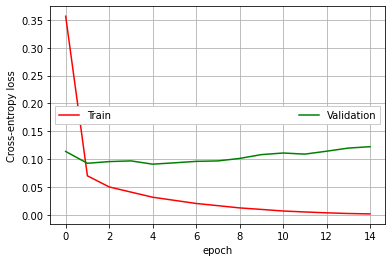

In [ ]:
x = list(range(len(train_losses)))
ax = plt.subplot(111)
plt.plot(x, train_losses, 'r', label="Train")
plt.plot(x, val_losses, 'g', label="Validation")
plt.xlabel('epoch')
plt.ylabel('Cross-entropy loss')
plt.grid()
leg = plt.legend(loc='best', ncol=2, mode="expand", shadow=False, fancybox=False)
leg.get_frame().set_alpha(0.99)

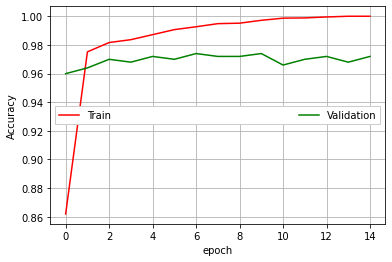

In [ ]:
x = list(range(len(train_accuracies)))
ax = plt.subplot(111)
plt.plot(x, train_accuracies, 'r', label="Train")
plt.plot(x, val_accuracies, 'g', label="Validation")
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.grid()
leg = plt.legend(loc='best', ncol=2, mode="expand", shadow=False, fancybox=False)
leg.get_frame().set_alpha(0.99)